# Tuning models with Optuna

In this notebook we will see how to tune the hyperparameters of a GlutonTS model using Optuna. For this example, we are going to tune a PyTorch-based DeepAREstimator.

**Note:** to keep the running time of this example short, here we consider a small-scale dataset, and tune only two hyperparameters over a very small number of tuning rounds ("trials"). In real applications, especially for larger datasets, you will probably need to increase the search space and increase the number of trials.

## Data loading and processing

In [1]:
import mxnet as mx
from mxnet import gluon
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

### Provided datasets

In [2]:
from gluonts.dataset.repository.datasets import get_dataset, dataset_recipes
from gluonts.dataset.util import to_pandas

In [3]:
print(f"Available datasets: {list(dataset_recipes.keys())}")

Available datasets: ['constant', 'exchange_rate', 'solar-energy', 'electricity', 'traffic', 'exchange_rate_nips', 'electricity_nips', 'traffic_nips', 'solar_nips', 'wiki-rolling_nips', 'taxi_30min', 'kaggle_web_traffic_with_missing', 'kaggle_web_traffic_without_missing', 'kaggle_web_traffic_weekly', 'm1_yearly', 'm1_quarterly', 'm1_monthly', 'nn5_daily_with_missing', 'nn5_daily_without_missing', 'nn5_weekly', 'tourism_monthly', 'tourism_quarterly', 'tourism_yearly', 'cif_2016', 'london_smart_meters_without_missing', 'wind_farms_without_missing', 'car_parts_without_missing', 'dominick', 'fred_md', 'pedestrian_counts', 'hospital', 'covid_deaths', 'kdd_cup_2018_without_missing', 'weather', 'm3_monthly', 'm3_quarterly', 'm3_yearly', 'm3_other', 'm4_hourly', 'm4_daily', 'm4_weekly', 'm4_monthly', 'm4_quarterly', 'm4_yearly', 'm5', 'uber_tlc_daily', 'uber_tlc_hourly']


In [4]:
dataset = get_dataset("m4_hourly")

### Extract and split training and test data sets

In general, the datasets provided by GluonTS are objects that consists of three things:

- `dataset.train` is an iterable collection of data entries used for training. Each entry corresponds to one time series
- `dataset.test` is an iterable collection of data entries used for inference. The test dataset is an extended version of the train dataset that contains a window in the end of each time series that was not seen during training. This window has length equal to the recommended prediction length.
- `dataset.metadata` contains metadata of the dataset such as the frequency of the time series, a recommended prediction horizon, associated features, etc.

We can check details of the `dataset.metadata`.

In [5]:
print(f"Recommended prediction horizon: {dataset.metadata.prediction_length}")
print(f"Frequency of the time series: {dataset.metadata.freq}")

Recommended prediction horizon: 48
Frequency of the time series: H


To keep the example small and quick to execute, we are only going to use a subset of the dataset.

In [6]:
from itertools import islice
train_subset = list(islice(dataset.train, 10))
test_subset = list(islice(dataset.test, 15))

This is what the data looks like (first training series, first two weeks of data)

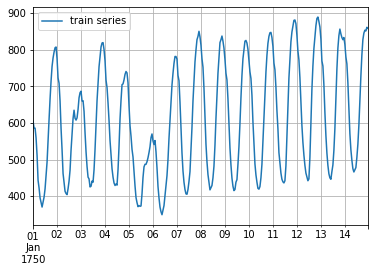

In [7]:
to_pandas(train_subset[0])[:14 * 24].plot()
plt.grid(which="both")
plt.legend(["train series"], loc="upper left")
plt.show()

## Tuning parameters of DeepAR estimator

In [8]:
import optuna
import torch
from gluonts.torch.model.deepar import DeepAREstimator
from gluonts.mx import Trainer
from gluonts.evaluation import Evaluator

/Users/stellalo/.virtualenvs/gluonts/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We will now tune the DeepAR estimator on our training data using Optuna. We choose two hyperparameters `num_layers` and `hidden_size` to optimize.

First, we define an `DeepARTuningObjective` class used in tuning process of Optuna.
The class can be configured with the dataset, prediction length and data frequency, and the metric to be used for evaluating the model.
In the `get_params` method, we define what hyperparameters to be tuned within given range.
In the `split_entry` method, we split each time series of the dataset into two part:
- `entry_past`: the training part 
- `entry_future`: the label part used in validation
In the `__call__` method, we define the way the `DeepAREstimator` is used in training and validation.

In [9]:
class DeepARTuningObjective:  
    def __init__(self, dataset, prediction_length, freq, metric_type="mean_wQuantileLoss"):
        self.dataset = dataset
        self.prediction_length = prediction_length
        self.freq = freq
        self.metric_type = metric_type

        entry_split = [self.split_entry(entry) for entry in self.dataset]
        self.entry_pasts = [entry[0] for entry in entry_split]
        self.entry_futures = [entry[1] for entry in entry_split]
    
    def get_params(self, trial) -> dict:
        return {
            "num_layers": trial.suggest_int("num_layers", 1, 5),
            "hidden_size": trial.suggest_int("hidden_size", 10, 50),
        }

    def split_entry(self, entry):
        entry_past = {}
        for key, value in entry.items():
            if key == "target":
                entry_past[key] = value[: -self.prediction_length]
            else:
                entry_past[key] = value

        df = pd.DataFrame(
            entry['target'],
            columns=[entry['item_id']],
            index=pd.period_range(
                start=entry['start'],
                periods=len(entry['target']),
                freq=self.freq
            )
        )

        return entry_past, df[-self.prediction_length:]
     
    def __call__(self, trial):
        params = self.get_params(trial)
        estimator = DeepAREstimator(
            num_layers=params['num_layers'],
            hidden_size=params['hidden_size'],
            prediction_length=self.prediction_length, 
            freq=self.freq,
            trainer_kwargs={
                "progress_bar_refresh_rate": 0, 
                "weights_summary": None, 
                "max_epochs": 5, 
            }
        )
        
        
        predictor = estimator.train(self.entry_pasts, cache_data=True)
        forecast_it = predictor.predict(self.entry_pasts)
        
        forecasts = list(forecast_it)
        
        evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
        agg_metrics, item_metrics = evaluator(self.entry_futures, forecasts, num_series=len(self.dataset))
        return agg_metrics[self.metric_type]

We can now invoke the Optuna tuning process.

In [10]:
import time
start_time = time.time()
study = optuna.create_study(direction="minimize")
study.optimize(DeepARTuningObjective(train_subset, dataset.metadata.prediction_length, dataset.metadata.freq),
               n_trials=10)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
print(time.time() - start_time)

[I 2022-06-13 10:52:45,201] A new study created in memory with name: no-name-781c374d-63af-4db8-93f6-5f1c4154a864


/Users/stellalo/.virtualenvs/gluonts/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
/Users/stellalo/.virtualenvs/gluonts/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:168: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  "Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed"
INFO:pytorch_lightning

INFO:pytorch_lightning.utilities.distributed:TPU available: False, using: 0 TPU cores


INFO:pytorch_lightning.utilities.distributed:IPU available: False, using: 0 IPUs


/Users/stellalo/.virtualenvs/gluonts/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:122: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")


INFO:pytorch_lightning.utilities.distributed:Epoch 0, global step 49: train_loss reached 9.39540 (best 9.39540), saving model to "/Users/stellalo/gluon-ts/lightning_logs/version_37/checkpoints/epoch=0-step=49.ckpt" as top 1


INFO:pytorch_lightning.utilities.distributed:Epoch 1, global step 99: train_loss reached 8.32613 (best 8.32613), saving model to "/Users/stellalo/gluon-ts/lightning_logs/version_37/checkpoints/epoch=1-step=99.ckpt" as top 1


INFO:pytorch_lightning.utilities.distributed:Epoch 2, global step 149: train_loss reached 8.20673 (best 8.20673), saving model to "/Users/stellalo/gluon-ts/lightning_logs/version_37/checkpoints/epoch=2-step=149.ckpt" as top 1


INFO:pytorch_lightning.utilities.distributed:Epoch 3, global step 199: train_loss was not in top 1


INFO:pytorch_lightning.utilities.distributed:Epoch 4, global step 249: train_loss was not in top 1


Running evaluation:   0%|                                                                            | 0/10 [00:00<?, ?it/s]

Running evaluation: 100%|██████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 152.77it/s]

/Users/stellalo/gluon-ts/src/gluonts/evaluation/metrics.py:105: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs(target - forecast)) / seasonal_error


/Users/stellalo/gluon-ts/src/gluonts/evaluation/metrics.py:154: RuntimeWarning: divide by zero encountered in true_divide
  return numerator / seasonal_error



/Users/stellalo/.virtualenvs/gluonts/lib/python3.7/site-packages/pandas/core/construction.py:759: UserWarning: Warning: converting a masked element to nan.
  subarr = np.array(arr, dtype=dtype, copy=copy)
[I 2022-06-13 10:53:12,753] Trial 0 finished with value: 0.10196187250347215 and parameters: {'num_layers': 5, 'hidden_size': 34}. Best is trial 0 with value: 0.10196187250347215.


/Users/stellalo/.virtualenvs/gluonts/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
/Users/stellalo/.virtualenvs/gluonts/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:168: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  "Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed"
INFO:pytorch_lightning

INFO:pytorch_lightning.utilities.distributed:TPU available: False, using: 0 TPU cores


INFO:pytorch_lightning.utilities.distributed:IPU available: False, using: 0 IPUs


/Users/stellalo/.virtualenvs/gluonts/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:122: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")


INFO:pytorch_lightning.utilities.distributed:Epoch 0, global step 49: train_loss reached 8.90309 (best 8.90309), saving model to "/Users/stellalo/gluon-ts/lightning_logs/version_38/checkpoints/epoch=0-step=49.ckpt" as top 1


INFO:pytorch_lightning.utilities.distributed:Epoch 1, global step 99: train_loss reached 7.91370 (best 7.91370), saving model to "/Users/stellalo/gluon-ts/lightning_logs/version_38/checkpoints/epoch=1-step=99.ckpt" as top 1


INFO:pytorch_lightning.utilities.distributed:Epoch 2, global step 149: train_loss reached 7.43913 (best 7.43913), saving model to "/Users/stellalo/gluon-ts/lightning_logs/version_38/checkpoints/epoch=2-step=149.ckpt" as top 1


INFO:pytorch_lightning.utilities.distributed:Epoch 3, global step 199: train_loss reached 7.33597 (best 7.33597), saving model to "/Users/stellalo/gluon-ts/lightning_logs/version_38/checkpoints/epoch=3-step=199.ckpt" as top 1


INFO:pytorch_lightning.utilities.distributed:Epoch 4, global step 249: train_loss reached 7.31664 (best 7.31664), saving model to "/Users/stellalo/gluon-ts/lightning_logs/version_38/checkpoints/epoch=4-step=249.ckpt" as top 1


Running evaluation:   0%|                                                                            | 0/10 [00:00<?, ?it/s]

Running evaluation: 100%|██████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 147.14it/s]

/Users/stellalo/gluon-ts/src/gluonts/evaluation/metrics.py:105: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs(target - forecast)) / seasonal_error


/Users/stellalo/gluon-ts/src/gluonts/evaluation/metrics.py:154: RuntimeWarning: divide by zero encountered in true_divide
  return numerator / seasonal_error



/Users/stellalo/.virtualenvs/gluonts/lib/python3.7/site-packages/pandas/core/construction.py:759: UserWarning: Warning: converting a masked element to nan.
  subarr = np.array(arr, dtype=dtype, copy=copy)
[I 2022-06-13 10:53:25,212] Trial 1 finished with value: 0.04440780978820091 and parameters: {'num_layers': 2, 'hidden_size': 37}. Best is trial 1 with value: 0.04440780978820091.


/Users/stellalo/.virtualenvs/gluonts/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
/Users/stellalo/.virtualenvs/gluonts/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:168: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  "Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed"
INFO:pytorch_lightning

INFO:pytorch_lightning.utilities.distributed:TPU available: False, using: 0 TPU cores


INFO:pytorch_lightning.utilities.distributed:IPU available: False, using: 0 IPUs


/Users/stellalo/.virtualenvs/gluonts/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:122: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")


INFO:pytorch_lightning.utilities.distributed:Epoch 0, global step 49: train_loss reached 8.83242 (best 8.83242), saving model to "/Users/stellalo/gluon-ts/lightning_logs/version_39/checkpoints/epoch=0-step=49.ckpt" as top 1


INFO:pytorch_lightning.utilities.distributed:Epoch 1, global step 99: train_loss reached 7.81890 (best 7.81890), saving model to "/Users/stellalo/gluon-ts/lightning_logs/version_39/checkpoints/epoch=1-step=99.ckpt" as top 1


INFO:pytorch_lightning.utilities.distributed:Epoch 2, global step 149: train_loss reached 7.49192 (best 7.49192), saving model to "/Users/stellalo/gluon-ts/lightning_logs/version_39/checkpoints/epoch=2-step=149.ckpt" as top 1


INFO:pytorch_lightning.utilities.distributed:Epoch 3, global step 199: train_loss reached 7.33423 (best 7.33423), saving model to "/Users/stellalo/gluon-ts/lightning_logs/version_39/checkpoints/epoch=3-step=199.ckpt" as top 1


INFO:pytorch_lightning.utilities.distributed:Epoch 4, global step 249: train_loss reached 7.22406 (best 7.22406), saving model to "/Users/stellalo/gluon-ts/lightning_logs/version_39/checkpoints/epoch=4-step=249.ckpt" as top 1


Running evaluation:   0%|                                                                            | 0/10 [00:00<?, ?it/s]

Running evaluation: 100%|██████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 150.90it/s]

/Users/stellalo/gluon-ts/src/gluonts/evaluation/metrics.py:105: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs(target - forecast)) / seasonal_error


/Users/stellalo/gluon-ts/src/gluonts/evaluation/metrics.py:154: RuntimeWarning: divide by zero encountered in true_divide
  return numerator / seasonal_error



/Users/stellalo/.virtualenvs/gluonts/lib/python3.7/site-packages/pandas/core/construction.py:759: UserWarning: Warning: converting a masked element to nan.
  subarr = np.array(arr, dtype=dtype, copy=copy)
[I 2022-06-13 10:53:39,546] Trial 2 finished with value: 0.030951219764136135 and parameters: {'num_layers': 2, 'hidden_size': 44}. Best is trial 2 with value: 0.030951219764136135.


/Users/stellalo/.virtualenvs/gluonts/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
/Users/stellalo/.virtualenvs/gluonts/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:168: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  "Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed"
INFO:pytorch_lightning

INFO:pytorch_lightning.utilities.distributed:TPU available: False, using: 0 TPU cores


INFO:pytorch_lightning.utilities.distributed:IPU available: False, using: 0 IPUs


/Users/stellalo/.virtualenvs/gluonts/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:122: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")


INFO:pytorch_lightning.utilities.distributed:Epoch 0, global step 49: train_loss reached 9.22823 (best 9.22823), saving model to "/Users/stellalo/gluon-ts/lightning_logs/version_40/checkpoints/epoch=0-step=49.ckpt" as top 1


INFO:pytorch_lightning.utilities.distributed:Epoch 1, global step 99: train_loss reached 8.34220 (best 8.34220), saving model to "/Users/stellalo/gluon-ts/lightning_logs/version_40/checkpoints/epoch=1-step=99.ckpt" as top 1


INFO:pytorch_lightning.utilities.distributed:Epoch 2, global step 149: train_loss reached 8.18275 (best 8.18275), saving model to "/Users/stellalo/gluon-ts/lightning_logs/version_40/checkpoints/epoch=2-step=149.ckpt" as top 1


INFO:pytorch_lightning.utilities.distributed:Epoch 3, global step 199: train_loss was not in top 1


INFO:pytorch_lightning.utilities.distributed:Epoch 4, global step 249: train_loss reached 8.14207 (best 8.14207), saving model to "/Users/stellalo/gluon-ts/lightning_logs/version_40/checkpoints/epoch=4-step=249.ckpt" as top 1


Running evaluation:   0%|                                                                            | 0/10 [00:00<?, ?it/s]

Running evaluation: 100%|██████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 148.15it/s]

/Users/stellalo/gluon-ts/src/gluonts/evaluation/metrics.py:105: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs(target - forecast)) / seasonal_error


/Users/stellalo/gluon-ts/src/gluonts/evaluation/metrics.py:154: RuntimeWarning: divide by zero encountered in true_divide
  return numerator / seasonal_error



/Users/stellalo/.virtualenvs/gluonts/lib/python3.7/site-packages/pandas/core/construction.py:759: UserWarning: Warning: converting a masked element to nan.
  subarr = np.array(arr, dtype=dtype, copy=copy)
[I 2022-06-13 10:53:56,937] Trial 3 finished with value: 0.10728555487360118 and parameters: {'num_layers': 4, 'hidden_size': 17}. Best is trial 2 with value: 0.030951219764136135.


/Users/stellalo/.virtualenvs/gluonts/lib/python3.7/site-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
/Users/stellalo/.virtualenvs/gluonts/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
/Users/stellalo/.virtualenvs/gluonts/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/call

INFO:pytorch_lightning.utilities.distributed:TPU available: False, using: 0 TPU cores


INFO:pytorch_lightning.utilities.distributed:IPU available: False, using: 0 IPUs


/Users/stellalo/.virtualenvs/gluonts/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:122: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")


INFO:pytorch_lightning.utilities.distributed:Epoch 0, global step 49: train_loss reached 9.24744 (best 9.24744), saving model to "/Users/stellalo/gluon-ts/lightning_logs/version_41/checkpoints/epoch=0-step=49.ckpt" as top 1


INFO:pytorch_lightning.utilities.distributed:Epoch 1, global step 99: train_loss reached 7.99981 (best 7.99981), saving model to "/Users/stellalo/gluon-ts/lightning_logs/version_41/checkpoints/epoch=1-step=99.ckpt" as top 1


INFO:pytorch_lightning.utilities.distributed:Epoch 2, global step 149: train_loss reached 7.21876 (best 7.21876), saving model to "/Users/stellalo/gluon-ts/lightning_logs/version_41/checkpoints/epoch=2-step=149.ckpt" as top 1


INFO:pytorch_lightning.utilities.distributed:Epoch 3, global step 199: train_loss reached 6.92423 (best 6.92423), saving model to "/Users/stellalo/gluon-ts/lightning_logs/version_41/checkpoints/epoch=3-step=199.ckpt" as top 1


INFO:pytorch_lightning.utilities.distributed:Epoch 4, global step 249: train_loss was not in top 1


Running evaluation:   0%|                                                                            | 0/10 [00:00<?, ?it/s]

Running evaluation: 100%|██████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 145.04it/s]

/Users/stellalo/gluon-ts/src/gluonts/evaluation/metrics.py:105: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs(target - forecast)) / seasonal_error


/Users/stellalo/gluon-ts/src/gluonts/evaluation/metrics.py:154: RuntimeWarning: divide by zero encountered in true_divide
  return numerator / seasonal_error



/Users/stellalo/.virtualenvs/gluonts/lib/python3.7/site-packages/pandas/core/construction.py:759: UserWarning: Warning: converting a masked element to nan.
  subarr = np.array(arr, dtype=dtype, copy=copy)
[I 2022-06-13 10:54:04,191] Trial 4 finished with value: 0.11914071167850086 and parameters: {'num_layers': 1, 'hidden_size': 32}. Best is trial 2 with value: 0.030951219764136135.


/Users/stellalo/.virtualenvs/gluonts/lib/python3.7/site-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
/Users/stellalo/.virtualenvs/gluonts/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
/Users/stellalo/.virtualenvs/gluonts/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/call

INFO:pytorch_lightning.utilities.distributed:TPU available: False, using: 0 TPU cores


INFO:pytorch_lightning.utilities.distributed:IPU available: False, using: 0 IPUs


/Users/stellalo/.virtualenvs/gluonts/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:122: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")


INFO:pytorch_lightning.utilities.distributed:Epoch 0, global step 49: train_loss reached 8.81847 (best 8.81847), saving model to "/Users/stellalo/gluon-ts/lightning_logs/version_42/checkpoints/epoch=0-step=49.ckpt" as top 1


INFO:pytorch_lightning.utilities.distributed:Epoch 1, global step 99: train_loss reached 7.86830 (best 7.86830), saving model to "/Users/stellalo/gluon-ts/lightning_logs/version_42/checkpoints/epoch=1-step=99.ckpt" as top 1


INFO:pytorch_lightning.utilities.distributed:Epoch 2, global step 149: train_loss reached 7.30677 (best 7.30677), saving model to "/Users/stellalo/gluon-ts/lightning_logs/version_42/checkpoints/epoch=2-step=149.ckpt" as top 1


INFO:pytorch_lightning.utilities.distributed:Epoch 3, global step 199: train_loss reached 7.10505 (best 7.10505), saving model to "/Users/stellalo/gluon-ts/lightning_logs/version_42/checkpoints/epoch=3-step=199.ckpt" as top 1


INFO:pytorch_lightning.utilities.distributed:Epoch 4, global step 249: train_loss reached 6.89428 (best 6.89428), saving model to "/Users/stellalo/gluon-ts/lightning_logs/version_42/checkpoints/epoch=4-step=249.ckpt" as top 1


Running evaluation:   0%|                                                                            | 0/10 [00:00<?, ?it/s]

Running evaluation: 100%|██████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 153.88it/s]

/Users/stellalo/gluon-ts/src/gluonts/evaluation/metrics.py:105: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs(target - forecast)) / seasonal_error


/Users/stellalo/gluon-ts/src/gluonts/evaluation/metrics.py:154: RuntimeWarning: divide by zero encountered in true_divide
  return numerator / seasonal_error



/Users/stellalo/.virtualenvs/gluonts/lib/python3.7/site-packages/pandas/core/construction.py:759: UserWarning: Warning: converting a masked element to nan.
  subarr = np.array(arr, dtype=dtype, copy=copy)
[I 2022-06-13 10:54:11,693] Trial 5 finished with value: 0.06764762503851333 and parameters: {'num_layers': 1, 'hidden_size': 34}. Best is trial 2 with value: 0.030951219764136135.


/Users/stellalo/.virtualenvs/gluonts/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
/Users/stellalo/.virtualenvs/gluonts/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:168: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  "Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed"
INFO:pytorch_lightning

INFO:pytorch_lightning.utilities.distributed:TPU available: False, using: 0 TPU cores


INFO:pytorch_lightning.utilities.distributed:IPU available: False, using: 0 IPUs


/Users/stellalo/.virtualenvs/gluonts/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:122: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")


INFO:pytorch_lightning.utilities.distributed:Epoch 0, global step 49: train_loss reached 9.41120 (best 9.41120), saving model to "/Users/stellalo/gluon-ts/lightning_logs/version_43/checkpoints/epoch=0-step=49.ckpt" as top 1


INFO:pytorch_lightning.utilities.distributed:Epoch 1, global step 99: train_loss reached 8.52601 (best 8.52601), saving model to "/Users/stellalo/gluon-ts/lightning_logs/version_43/checkpoints/epoch=1-step=99.ckpt" as top 1


INFO:pytorch_lightning.utilities.distributed:Epoch 2, global step 149: train_loss reached 8.11307 (best 8.11307), saving model to "/Users/stellalo/gluon-ts/lightning_logs/version_43/checkpoints/epoch=2-step=149.ckpt" as top 1


INFO:pytorch_lightning.utilities.distributed:Epoch 3, global step 199: train_loss reached 7.94941 (best 7.94941), saving model to "/Users/stellalo/gluon-ts/lightning_logs/version_43/checkpoints/epoch=3-step=199.ckpt" as top 1


INFO:pytorch_lightning.utilities.distributed:Epoch 4, global step 249: train_loss reached 7.61962 (best 7.61962), saving model to "/Users/stellalo/gluon-ts/lightning_logs/version_43/checkpoints/epoch=4-step=249.ckpt" as top 1


Running evaluation:   0%|                                                                            | 0/10 [00:00<?, ?it/s]

Running evaluation: 100%|██████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 155.78it/s]

/Users/stellalo/gluon-ts/src/gluonts/evaluation/metrics.py:105: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs(target - forecast)) / seasonal_error


/Users/stellalo/gluon-ts/src/gluonts/evaluation/metrics.py:154: RuntimeWarning: divide by zero encountered in true_divide
  return numerator / seasonal_error



/Users/stellalo/.virtualenvs/gluonts/lib/python3.7/site-packages/pandas/core/construction.py:759: UserWarning: Warning: converting a masked element to nan.
  subarr = np.array(arr, dtype=dtype, copy=copy)
[I 2022-06-13 10:54:21,350] Trial 6 finished with value: 0.07809908381866705 and parameters: {'num_layers': 2, 'hidden_size': 15}. Best is trial 2 with value: 0.030951219764136135.


/Users/stellalo/.virtualenvs/gluonts/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
/Users/stellalo/.virtualenvs/gluonts/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:168: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  "Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed"
INFO:pytorch_lightning

INFO:pytorch_lightning.utilities.distributed:TPU available: False, using: 0 TPU cores


INFO:pytorch_lightning.utilities.distributed:IPU available: False, using: 0 IPUs


/Users/stellalo/.virtualenvs/gluonts/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:122: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")


INFO:pytorch_lightning.utilities.distributed:Epoch 0, global step 49: train_loss reached 9.51806 (best 9.51806), saving model to "/Users/stellalo/gluon-ts/lightning_logs/version_44/checkpoints/epoch=0-step=49.ckpt" as top 1


INFO:pytorch_lightning.utilities.distributed:Epoch 1, global step 99: train_loss reached 8.60261 (best 8.60261), saving model to "/Users/stellalo/gluon-ts/lightning_logs/version_44/checkpoints/epoch=1-step=99.ckpt" as top 1


INFO:pytorch_lightning.utilities.distributed:Epoch 2, global step 149: train_loss reached 8.18151 (best 8.18151), saving model to "/Users/stellalo/gluon-ts/lightning_logs/version_44/checkpoints/epoch=2-step=149.ckpt" as top 1


INFO:pytorch_lightning.utilities.distributed:Epoch 3, global step 199: train_loss reached 8.13575 (best 8.13575), saving model to "/Users/stellalo/gluon-ts/lightning_logs/version_44/checkpoints/epoch=3-step=199.ckpt" as top 1


INFO:pytorch_lightning.utilities.distributed:Epoch 4, global step 249: train_loss reached 7.73799 (best 7.73799), saving model to "/Users/stellalo/gluon-ts/lightning_logs/version_44/checkpoints/epoch=4-step=249.ckpt" as top 1


Running evaluation:   0%|                                                                            | 0/10 [00:00<?, ?it/s]

Running evaluation: 100%|██████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 151.27it/s]

/Users/stellalo/gluon-ts/src/gluonts/evaluation/metrics.py:105: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs(target - forecast)) / seasonal_error


/Users/stellalo/gluon-ts/src/gluonts/evaluation/metrics.py:154: RuntimeWarning: divide by zero encountered in true_divide
  return numerator / seasonal_error



/Users/stellalo/.virtualenvs/gluonts/lib/python3.7/site-packages/pandas/core/construction.py:759: UserWarning: Warning: converting a masked element to nan.
  subarr = np.array(arr, dtype=dtype, copy=copy)
[I 2022-06-13 10:54:33,870] Trial 7 finished with value: 0.07525284863553329 and parameters: {'num_layers': 3, 'hidden_size': 13}. Best is trial 2 with value: 0.030951219764136135.


/Users/stellalo/.virtualenvs/gluonts/lib/python3.7/site-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


/Users/stellalo/.virtualenvs/gluonts/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
/Users/stellalo/.virtualenvs/gluonts/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:168: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  "Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed"
INFO:pytorch_lightning

INFO:pytorch_lightning.utilities.distributed:TPU available: False, using: 0 TPU cores


INFO:pytorch_lightning.utilities.distributed:IPU available: False, using: 0 IPUs


/Users/stellalo/.virtualenvs/gluonts/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:122: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")


INFO:pytorch_lightning.utilities.distributed:Epoch 0, global step 49: train_loss reached 8.83128 (best 8.83128), saving model to "/Users/stellalo/gluon-ts/lightning_logs/version_45/checkpoints/epoch=0-step=49.ckpt" as top 1


INFO:pytorch_lightning.utilities.distributed:Epoch 1, global step 99: train_loss reached 7.74608 (best 7.74608), saving model to "/Users/stellalo/gluon-ts/lightning_logs/version_45/checkpoints/epoch=1-step=99.ckpt" as top 1


INFO:pytorch_lightning.utilities.distributed:Epoch 2, global step 149: train_loss reached 7.26593 (best 7.26593), saving model to "/Users/stellalo/gluon-ts/lightning_logs/version_45/checkpoints/epoch=2-step=149.ckpt" as top 1


INFO:pytorch_lightning.utilities.distributed:Epoch 3, global step 199: train_loss reached 7.06662 (best 7.06662), saving model to "/Users/stellalo/gluon-ts/lightning_logs/version_45/checkpoints/epoch=3-step=199.ckpt" as top 1


INFO:pytorch_lightning.utilities.distributed:Epoch 4, global step 249: train_loss reached 6.96181 (best 6.96181), saving model to "/Users/stellalo/gluon-ts/lightning_logs/version_45/checkpoints/epoch=4-step=249.ckpt" as top 1


Running evaluation:   0%|                                                                            | 0/10 [00:00<?, ?it/s]

Running evaluation: 100%|██████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 143.05it/s]

/Users/stellalo/gluon-ts/src/gluonts/evaluation/metrics.py:105: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs(target - forecast)) / seasonal_error


/Users/stellalo/gluon-ts/src/gluonts/evaluation/metrics.py:154: RuntimeWarning: divide by zero encountered in true_divide
  return numerator / seasonal_error



/Users/stellalo/.virtualenvs/gluonts/lib/python3.7/site-packages/pandas/core/construction.py:759: UserWarning: Warning: converting a masked element to nan.
  subarr = np.array(arr, dtype=dtype, copy=copy)
[I 2022-06-13 10:54:42,016] Trial 8 finished with value: 0.06853983331870474 and parameters: {'num_layers': 1, 'hidden_size': 43}. Best is trial 2 with value: 0.030951219764136135.


/Users/stellalo/.virtualenvs/gluonts/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=0)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
/Users/stellalo/.virtualenvs/gluonts/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:168: LightningDeprecationWarning: Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed in v1.7. Please set `Trainer(enable_model_summary=False)` instead.
  "Setting `Trainer(weights_summary=None)` is deprecated in v1.5 and will be removed"
INFO:pytorch_lightning

INFO:pytorch_lightning.utilities.distributed:TPU available: False, using: 0 TPU cores


INFO:pytorch_lightning.utilities.distributed:IPU available: False, using: 0 IPUs


/Users/stellalo/.virtualenvs/gluonts/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:122: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")


INFO:pytorch_lightning.utilities.distributed:Epoch 0, global step 49: train_loss reached 9.33411 (best 9.33411), saving model to "/Users/stellalo/gluon-ts/lightning_logs/version_46/checkpoints/epoch=0-step=49.ckpt" as top 1


INFO:pytorch_lightning.utilities.distributed:Epoch 1, global step 99: train_loss reached 8.42259 (best 8.42259), saving model to "/Users/stellalo/gluon-ts/lightning_logs/version_46/checkpoints/epoch=1-step=99.ckpt" as top 1


INFO:pytorch_lightning.utilities.distributed:Epoch 2, global step 149: train_loss reached 8.19973 (best 8.19973), saving model to "/Users/stellalo/gluon-ts/lightning_logs/version_46/checkpoints/epoch=2-step=149.ckpt" as top 1


INFO:pytorch_lightning.utilities.distributed:Epoch 3, global step 199: train_loss was not in top 1


INFO:pytorch_lightning.utilities.distributed:Epoch 4, global step 249: train_loss was not in top 1


Running evaluation:   0%|                                                                            | 0/10 [00:00<?, ?it/s]

Running evaluation: 100%|██████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 152.05it/s]

/Users/stellalo/gluon-ts/src/gluonts/evaluation/metrics.py:105: RuntimeWarning: divide by zero encountered in true_divide
  return np.mean(np.abs(target - forecast)) / seasonal_error


/Users/stellalo/gluon-ts/src/gluonts/evaluation/metrics.py:154: RuntimeWarning: divide by zero encountered in true_divide
  return numerator / seasonal_error



/Users/stellalo/.virtualenvs/gluonts/lib/python3.7/site-packages/pandas/core/construction.py:759: UserWarning: Warning: converting a masked element to nan.
  subarr = np.array(arr, dtype=dtype, copy=copy)
[I 2022-06-13 10:55:04,912] Trial 9 finished with value: 0.10841611549134818 and parameters: {'num_layers': 5, 'hidden_size': 22}. Best is trial 2 with value: 0.030951219764136135.


Number of finished trials: 10
Best trial:
  Value: 0.030951219764136135
  Params: 
    num_layers: 2
    hidden_size: 44
139.71694898605347


## Re-training the model

After getting the best hyperparameters by optuna, you can set them into the DeepAR estimator to re-train the model on the whole training subset we consider here.

In [11]:
estimator = DeepAREstimator(
    num_layers=trial.params["num_layers"],
    hidden_size=trial.params["hidden_size"],
    prediction_length=dataset.metadata.prediction_length,
    context_length=100,
    freq=dataset.metadata.freq,
    trainer_kwargs={
        "progress_bar_refresh_rate": 0, 
        "weights_summary": None, 
        "max_epochs": 5,
    }
)

After specifying our estimator with all the necessary hyperparameters we can train it using our training dataset `train_subset` by invoking the `train` method of the estimator. The training algorithm returns a fitted model (or a `Predictor` in GluonTS parlance) that can be used to obtain forecasts.

In [12]:
predictor = estimator.train(train_subset, cache_data=True)

INFO:pytorch_lightning.utilities.distributed:GPU available: False, used: False


INFO:pytorch_lightning.utilities.distributed:TPU available: False, using: 0 TPU cores


INFO:pytorch_lightning.utilities.distributed:IPU available: False, using: 0 IPUs


INFO:pytorch_lightning.utilities.distributed:Epoch 0, global step 49: train_loss reached 8.74808 (best 8.74808), saving model to "/Users/stellalo/gluon-ts/lightning_logs/version_47/checkpoints/epoch=0-step=49.ckpt" as top 1


INFO:pytorch_lightning.utilities.distributed:Epoch 1, global step 99: train_loss reached 7.86609 (best 7.86609), saving model to "/Users/stellalo/gluon-ts/lightning_logs/version_47/checkpoints/epoch=1-step=99.ckpt" as top 1


INFO:pytorch_lightning.utilities.distributed:Epoch 2, global step 149: train_loss reached 7.34627 (best 7.34627), saving model to "/Users/stellalo/gluon-ts/lightning_logs/version_47/checkpoints/epoch=2-step=149.ckpt" as top 1


INFO:pytorch_lightning.utilities.distributed:Epoch 3, global step 199: train_loss reached 7.27368 (best 7.27368), saving model to "/Users/stellalo/gluon-ts/lightning_logs/version_47/checkpoints/epoch=3-step=199.ckpt" as top 1


INFO:pytorch_lightning.utilities.distributed:Epoch 4, global step 249: train_loss reached 7.08829 (best 7.08829), saving model to "/Users/stellalo/gluon-ts/lightning_logs/version_47/checkpoints/epoch=4-step=249.ckpt" as top 1


## Visualize and evaluate forecasts

With a predictor in hand, we can now predict the last window of the test dataset and evaluate our model's performance.

GluonTS comes with the `make_evaluation_predictions` function that automates the process of prediction and model evaluation. Roughly, this function performs the following steps:

- Removes the final window of length `prediction_length` of the test dataset that we want to predict
- The estimator uses the remaining data to predict (in the form of sample paths) the "future" window that was just removed
- The forecasts are returned, together with ground truth values for the same time range (as python generator objects)

In [13]:
from gluonts.evaluation import make_evaluation_predictions
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_subset,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

First, we can convert these generators to lists to ease the subsequent computations.

In [14]:
forecasts = list(forecast_it)
tss = list(ts_it)

We can examine the first element of these lists (that corresponds to the first time series of the dataset). Let's start with the list containing the time series, i.e., `tss`. We expect the first entry of `tss` to contain the (target of the) first time series in the test data.

In [15]:
# first entry of the time series list
ts_entry = tss[0]
# first entry of the forecast list
forecast_entry = forecasts[0]

`Forecast` objects have a `plot` method that can summarize the forecast paths as the mean, prediction intervals, etc. The prediction intervals are shaded in different colors as a "fan chart".

In [16]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 150
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

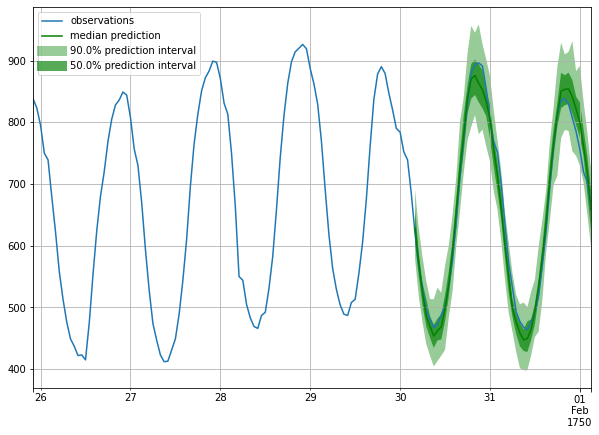

In [17]:
plot_prob_forecasts(ts_entry, forecast_entry)

We can also evaluate the quality of our forecasts numerically. In GluonTS, the `Evaluator` class can compute aggregate performance metrics, as well as metrics per time series (which can be useful for analyzing performance across heterogeneous time series).

In [18]:
from gluonts.evaluation import Evaluator

In [19]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_subset))

Running evaluation:   0%|                                                                            | 0/15 [00:00<?, ?it/s]

Running evaluation: 100%|██████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 226.27it/s]

Aggregate metrics aggregate both across time-steps and across time series.

In [20]:
print(json.dumps(agg_metrics, indent=4))

{
    "MSE": 1631333.3448649088,
    "abs_error": 532850.5944213867,
    "abs_target_sum": 8874460.0,
    "abs_target_mean": 12325.638888888889,
    "seasonal_error": 632.8422090729782,
    "MASE": 1.4710131333107954,
    "MAPE": 0.07181637419594658,
    "sMAPE": 0.07433987160523732,
    "MSIS": 11.570866484119245,
    "QuantileLoss[0.1]": 210431.67215118412,
    "Coverage[0.1]": 0.06527777777777778,
    "QuantileLoss[0.5]": 532850.5947265625,
    "Coverage[0.5]": 0.2236111111111111,
    "QuantileLoss[0.9]": 255173.20389099116,
    "Coverage[0.9]": 0.5861111111111111,
    "RMSE": 1277.2366048876413,
    "NRMSE": 0.1036243732597929,
    "ND": 0.060043156926887574,
    "wQuantileLoss[0.1]": 0.02371205370819003,
    "wQuantileLoss[0.5]": 0.06004315696127567,
    "wQuantileLoss[0.9]": 0.02875365981603288,
    "mean_absolute_QuantileLoss": 332818.49025624595,
    "mean_wQuantileLoss": 0.03750295682849953,
    "MAE_Coverage": 0.20833333333333334,
    "OWA": NaN
}


Individual metrics are aggregated only across time-steps.

In [21]:
item_metrics.head()

,item_id,MSE,abs_error,abs_target_sum,abs_target_mean,seasonal_error,MASE,MAPE,sMAPE,ND,MSIS,QuantileLoss[0.1],Coverage[0.1],QuantileLoss[0.5],Coverage[0.5],QuantileLoss[0.9],Coverage[0.9]
0,0.0,437.562215,831.172974,31644.0,659.250000,42.371302,0.408675,0.026466,0.026598,0.026266,3.726400,449.949176,0.020833,831.173004,0.500000,437.219464,1.000000
1,1.0,97690.072917,13926.902344,124149.0,2586.437500,165.107988,1.757297,0.115698,0.108403,0.112179,8.385306,8763.240698,0.729167,13926.903076,1.000000,4754.824902,1.000000
2,2.0,67993.072917,10637.665039,65030.0,1354.791667,78.889053,2.809237,0.151517,0.166764,0.163581,54.204008,2873.045337,0.000000,10637.664917,0.000000,12917.273718,0.083333
3,3.0,148313.979167,14045.286133,235783.0,4912.145833,258.982249,1.129846,0.057710,0.058371,0.059569,7.540984,7728.985352,0.083333,14045.285889,0.104167,6085.282959,0.625000
4,4.0,29790.520833,6731.618164,131088.0,2731.000000,200.494083,0.699482,0.051669,0.053241,0.051352,3.917795,2796.244556,0.000000,6731.618042,0.145833,2637.351074,0.687500


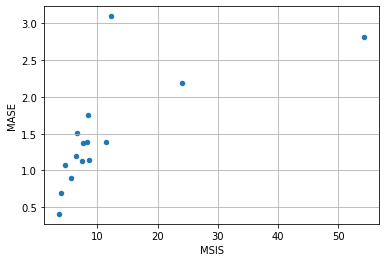

In [22]:
item_metrics.plot(x='MSIS', y='MASE', kind='scatter')
plt.grid(which="both")
plt.show()